In [3]:
1

1

# 案例描述

图像生成技术的目的是生成与原始数据集相近的图像。随着深度学习技术的发展，图像生成的效果也有了较大的提升。在人脸修复、头像生成、图像样本增加等方面有广泛应用。

本案例使用DCGAN算法生成动漫头像，得到较好的结果，并与VAE算法的图像生成效果进行对比。

# 目录
[1. 数据集简介](#1)<br>
[2. DCGAN模型介绍](#2)<br>
[3. 数据预处理](#3)<br>
[4. DCGAN模型构建](#4)<br>
[5. 模型训练](#5)<br>
[6. 图像生成效果](#6)<br>
[7. VAE模型介绍](#7)<br>
[8. VAE模型构建与训练](#8)<br>
[9. 模型效果对比](#9)<br>
[10. 总结](#10)<br>




<div id="1"></div>
# 1 数据集简介

动漫头像数据集大小为396MB，包含6万张以上动漫头像。图像保存为`jpg`格式，每张图像的大小不一致，但图像的宽度和高度相等，都为彩色图像。如下图所示，图像中只包含动漫人物的脸部信息。



<div id="2"></div>
# 2 DCGAN模型介绍

生成式对抗网络（GAN）以零和博弈与对抗训练的思想，生成高质量的样本，在样本生成领域取得了显著的成功。DCGAN（Deep Convolutional GAN）将卷积神经网络和GAN结合起来，保证了生成的图片质量和多样性。

模型主要分为两部分：生成网络和判别网络。
+ 判别网络：使用卷积神经网络作为判别器。其中输入数据为真实图像和生成图像；输出数据为，生成器认为该图像为真实图像的概率；

+ 生成网络：使用生成器，将随机生成的向量转换为图像，不断训练该生成器，使得生成图像接近真实图像，即判别网络对真实图像和生成图像的分值接近。

DCGAN的网络结构如下，该算法使用了一系列的训练技巧，如：
+ 添加BN层（批量归一化）稳定训练；
+ 使用全卷积层替代池化层；
+ 使用ReLU激活函数降低梯度消失风险。




<div id="3"></div>
# 3 数据预处理

首先加载动漫头像数据集，并进行数据预处理。

In [ ]:
!apt install unzip
!unzip Animefaces.zip

加载所需要的库，方便在之后调用相应的函数。

In [46]:
%matplotlib inline
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from __future__ import print_function
import numpy as np
import argparse
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML
import tqdm
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display, FileLink

设置随机种子，让数据集的训练结果可以复现。

In [47]:
# 随机种子的数值
manualSeed = 999
print("Random Seed: ", manualSeed)

# 设置随机种子
random.seed(manualSeed)
# 设置Pytorch的随机种子
torch.manual_seed(manualSeed) 

Random Seed:  999


在加载数据集前，我们需要设定部分参数的值，例如`image_size`为图像转换后的大小，`batch_size`为一个批次包含的图像数量。

In [48]:
dataroot = "/content/Animefaces/animeface" # 数据集路径
workers = 8
image_size = 64 # 图像转换后大小
batch_size = 128 # 每批次图像数量
gpu = True # 采用GPU进行训练
device = torch.device("cuda:0" if (torch.cuda.is_available() and gpu) else "cpu")
print(device)

cuda:0


接下来我们使用`ImageFolder`函数读取数据，并对图像进行处理。即图像大小调整为$64 \times 64$像素，并对像素值进行标准化处理。

In [27]:
# 读取数据、数据处理
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

之后我们再使用`torch.utils.data.DataLoader`函数读取数据，使得在训练过程中，模型能够分批次处理数据。可以看到，数据集共被分为497批次数据，每批次中有128张图像。

In [28]:
# 数据集分批次
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
print("批次数量： ",len(dataloader))

批次数量：  497


通过作图，可以观察数据集中的图像。如下图，我们随机抽取了16张图像展示数据集中的数据。

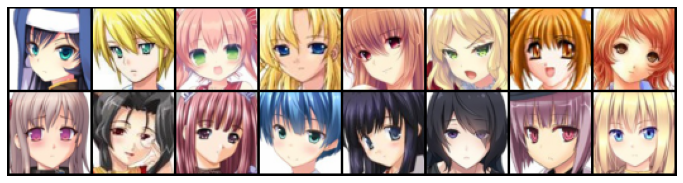

In [32]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(12,12))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0))) #normalize from [-1,1] to [0,1] again
plt.show()

<div id="4"></div>
# 4 DCGAN模型构建

现在可以构建DCGAN模型，以根据数据集生成图像。如前所述，模型分为两部分：生成网络和判别网络。

首先定义生成网络的结构，生成器将随机生成的向量，转换为与数据集相似的图像。本案例中，生成器的输入数据为$100 \times 1 \times 1$的向量，输出数据为$3 \times 64 \times 64$的图像。

In [ ]:
class Generator(nn.Module):
  # 生成网络
  def __init__(self):
    super(Generator, self).__init__()
    
    # (100,1,1) 转换为 (512,4,4)
    self.convT_block1 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )

    # (512,4,4)转换为(256,8,8)
    self.convT_block2 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )

    # (256,8,8)转换为(128,16,16)
    self.convT_block3 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU()
    )

    # (128,16,16)转换为(64,32,32)
    self.convT_block4 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

    # (64,32,32)转换为(3,64,64)
    self.convT_block5 = nn.Sequential(
        #64 x 32 x 32
        nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )
        #3 x 64 x 64

  def forward(self, x):
    x = self.convT_block1(x)
    x = self.convT_block2(x)
    x = self.convT_block3(x)
    x = self.convT_block4(x)
    x = self.convT_block5(x)
    return x

加下来构建判别网络的结构，本案例采用CNN网络作为判别器，对生成
图像和真实图像打分。网络共包含5层卷积层，输入数据为$3 \times 64 \times 64$的彩色图像；输出数据为该图像为真实图像的概率。下图为判别网络中卷积层转换数据的过程。

In [ ]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()
    
    # 将(3,64,64)维图像转换为(64,32,32)
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(negative_slope=0.2)
    )

    # (64,32,32)转换为(128,16,16)
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=128),
        nn.LeakyReLU(negative_slope=0.2)
    )

    # (128,16,16)转换为(256,8,8)
    self.conv_block3 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=256),
        nn.LeakyReLU(negative_slope=0.2)
    )

    # (256,8,8)转换为(512,4,4)
    self.conv_block4 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=512),
        nn.LeakyReLU(negative_slope=0.2)
    )

    # (512,4,4)转换为(1,1,1)
    self.conv_block5 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.conv_block3(x)
    x = self.conv_block4(x)
    x = self.conv_block5(x)
    return x

<div id="5"></div>
# 5 模型训练

定义网络结构、处理数据集完成后，我们可以将数据集代入模型，开始训练模型。

首先初始化模型权重，设定卷积层的权重符合特定的正态分布。


In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)

In [ ]:
# 设定判别网络的权重
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

Discriminator(
  (conv_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv_block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv_block4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv_block5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), st

In [ ]:
# 设定生成网络的权重
generator = Generator().to(device)
generator.apply(weights_init)

Generator(
  (convT_block1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convT_block2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convT_block3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convT_block4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convT_block5): Sequential(
    (0): ConvTranspose2d(

此外，我们采取二分类交叉熵损失函数，以及Adam算法优化模型参数。

In [ ]:
# 损失函数
criterion = nn.BCELoss()

# Adam算法
lr = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))


接下来对参数赋初始值，以便模型调用。

In [ ]:
# 随机生成的向量，将其转换为生成图像
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# 参数初始值
img_list = []
G_losses = []
D_losses = []
iters = 0

现在开始训练模型，本案例选择训练30个Epoch（训练一次Epoch指神经网络将数据集中所有图像训练了一次）。并输出训练过程中，生成网络和判别网络的损失值变化，同时保存生成图像。

In [ ]:
num_epochs = 30
print("Starting Training Loop...")

# 模型训练过程
for epoch in range(num_epochs):
    # 每个Epoch中，数据集分批次训练
    for i, data in enumerate(dataloader, 0):
      # 加载真实图像
      data_real = data[0].to(device)

      # 计算该批次中包含的图像数量（最后一批次可能不为128张图像）
      b_size = data_real.size(0)

      # 真实图像和生成图像的标签
      label_real = torch.full(size=(b_size,), fill_value=1).to(device)
      label_fake = torch.full(size=(b_size,), fill_value=0).to(device)

      # 用真实图像训练判别器
      discriminator.zero_grad() # 初始化梯度值
      # 前向传播，对真实图像打分
      output_d_real = discriminator(data_real).view(-1)
      # 计算真实图像损失值
      loss_d_real = criterion(output_d_real.double(), label_real.double())
      # 反向传播优化参数
      loss_d_real.backward()

      # 用生成图像训练判别器
      # 生成向量，并将其转换为图像
      z = torch.randn(b_size, 100, 1, 1, device=device)
      data_fake = generator(z)
      # 前向传播，对生成图像打分
      output_d_fake = discriminator(data_fake.detach()).view(-1) 
      # 计算生成图像损失值
      loss_d_fake = criterion(output_d_fake.double(), label_fake.double())
      # 反向传播
      loss_d_fake.backward()

      # 总损失值
      loss_d = loss_d_real + loss_d_fake
      # 更新判别器参数
      optimizerD.step()

      # 训练生成网络
      generator.zero_grad()
      # 再次使用判别器，对生成图像打分
      output_g = discriminator(data_fake).view(-1)
      loss_g = criterion(output_g.double(), label_real.double())
      loss_g.backward()

      # 更新生成器参数
      optimizerG.step()

      # 记录损失值
      G_losses.append(loss_d.item())
      D_losses.append(loss_g.item())

      # 设置指标判断生成器和判别器的表现
      D_x = output_d_real.mean().item() * 100
      D_G_z1 = output_d_fake.mean().item() * 100
      D_G_z2 = output_g.mean().item() * 100

      
      iters += 1
    
    # 打印训练过程中生成图像效果的变化，如损失值、判别图像准确率等指标
    if ((epoch+1) % 5 == 0 or epoch == 0):
      print("Epoch [{:02d}/{:02d}], D_loss: {:06.3f}, G_loss: {:06.3f}. Real images recognized as real: {:05.2f}%. Fake images fooled by: {:05.2f}% and {:05.2f}%.".format(epoch+1, num_epochs, loss_d.item(), loss_g.item(), D_x, D_G_z1, D_G_z2))

      # 保存生成的图像
      with torch.no_grad():
        fake = generator(fixed_noise).detach().cpu()
      img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

Starting Training Loop...
Epoch [01/30], D_loss: 01.678, G_loss: 10.112. Real images recognized as real: 95.93%. Fake images fooled by: 73.14% and 00.02%.
Epoch [05/30], D_loss: 00.285, G_loss: 05.478. Real images recognized as real: 92.86%. Fake images fooled by: 15.77% and 00.73%.
Epoch [10/30], D_loss: 00.635, G_loss: 05.400. Real images recognized as real: 96.23%. Fake images fooled by: 39.14% and 00.76%.
Epoch [15/30], D_loss: 00.231, G_loss: 03.068. Real images recognized as real: 97.50%. Fake images fooled by: 17.23% and 06.52%.
Epoch [20/30], D_loss: 00.236, G_loss: 04.022. Real images recognized as real: 91.55%. Fake images fooled by: 12.58% and 02.64%.
Epoch [25/30], D_loss: 00.246, G_loss: 03.304. Real images recognized as real: 86.65%. Fake images fooled by: 07.96% and 05.36%.
Epoch [30/30], D_loss: 00.101, G_loss: 04.712. Real images recognized as real: 97.52%. Fake images fooled by: 06.91% and 01.37%.


<div id="6"></div>
# 6 图像生成效果

观察图像生成的效果，首先可以观察训练过程中损失值的变化。如下图展示了训练过程中，每个批次的损失值。可以看出，随着训练批次的增加，判别网络和生成网络的损失值都有下降趋势。


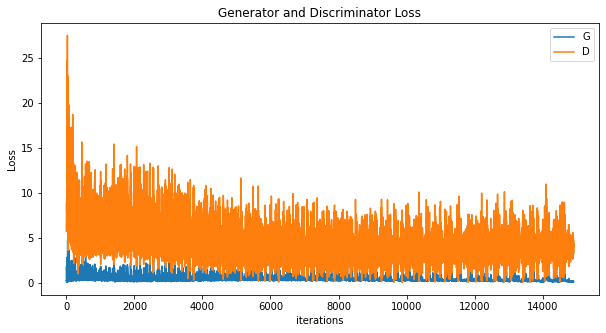

In [ ]:
# 判别网络和生成网络的损失值
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

为了更加直观地展示训练过程中生成图像的变化。我们展示每次经过5个Epoch后，模型生成图像的效果。由下图可以观察到，随着训练次数的增加，生成的图像越加清晰，边缘部分也更加接近真实图像。

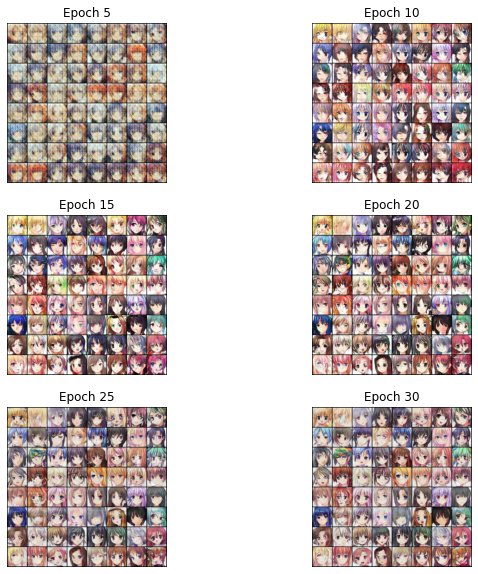

In [ ]:
# 设置图像大小
plt.figure(figsize=(10,10))

# 展示生成图像
for i in range(6): 
  plt.subplot(3,2,(i+1)) 
  plt.imshow(np.transpose(img_list[(i)].cpu(),(1,2,0)))
  plt.axis("off")
  plt.title("Epoch "+str(5*(i+1)))
plt.show()

下图中，我们将最终生成的图像（右图）与真实图像（左图）进行对比，可以发现模型的生成效果较好，生成图像基本与真实图像高度相似。

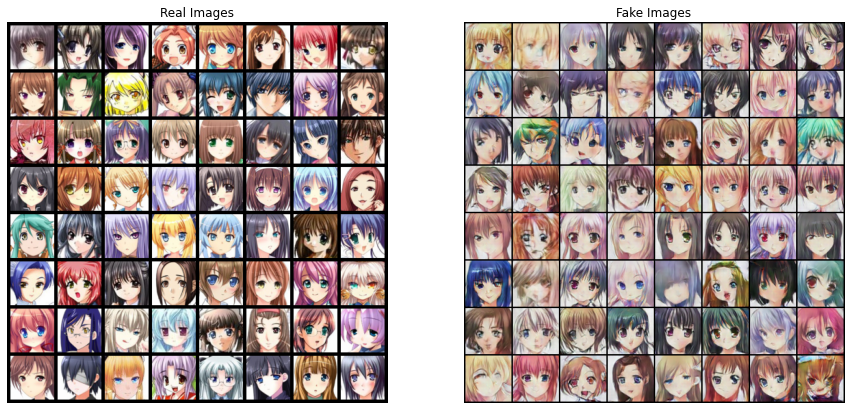

In [ ]:
real_batch = next(iter(dataloader))

# 展示真实图像
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 展示生成图像
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1].cpu(),(1,2,0)))
plt.show()

<div id="7"></div>
# 7 VAE模型介绍

VAE也是常用的算法，用以生成与数据集相似的图像。下图为VAE算法的网络结构。与DCGAN网络相似，VAE算法也主要分为两个部分：推断网络和生成网络。

+ 推断网络：使用编码器，将真实图像编码为隐变量;
+ 生成网络：使用解码器，通过隐变量，生成新的图像。




<div id="8"></div>
# 8 VAE模型构建与训练

与构建DCGAN模型类似，我们先加载数据集，再构建VAE模型。图像大小同样处理为$64 \times 64$像素，但每批次包含32张图像。


In [49]:
batch_size = 32
image_size = 64
torch.cuda.set_device("cuda:0")

In [50]:
dset = dset.ImageFolder(root="/content/Animefaces/animeface",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                           ]))
# 按照给定的长度，将数据集划分成没有重叠的新数据集组合
dataset, _ = torch.utils.data.random_split(dset, [len(dset)//2, len(dset)-len(dset)//2])
del _
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, drop_last=True, shuffle=True)


构建VAE模型，因为模型需要将图像编码为隐变量，并且根据隐变量，解码成新图像。我们需要定义编码器、解码器、损失函数。

In [11]:
# 接入全连接层前，将数据返回成一维的数组
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
# 反扁平化
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [12]:
# VAE模型
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super().__init__()
        
        # 编码器
        self.encoder = nn.Sequential(
            # 卷积层和ReLU激活函数
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),nn.ReLU(),
            # 扁平化，变为一维数组
            Flatten()
        )
        
        # 全连接层
        self.h2mu = nn.Linear(h_dim, z_dim)
        self.h2sigma = nn.Linear(h_dim, z_dim)
        self.z2h = nn.Linear(z_dim, h_dim)
        
        # 解码器
        self.decoder = nn.Sequential(
            # 反扁平化
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),nn.Sigmoid(),
        )

    # 采样，生成隐变量
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size())
        z = mu + std * eps
        return z
    
    # 减少参数量和计算量
    def bottleneck(self, h):
        mu = self.h2mu(h)
        logvar = self.h2sigma(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
    
    def encode(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def decode(self, z):
        return self.decoder(self.z2h(z))
    
    # 前向传播
    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.z2h(z)
        return self.decoder(z), mu, logvar

In [13]:
# 设置损失函数
def vae_loss(recon_x, x, mu, logvar) -> float:
    BCE = F.binary_cross_entropy(recon_x.view(-1, image_size*image_size*3),
                                 x.view(-1, image_size*image_size*3), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 加载模型
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

现在我们可以开始训练VAE模型，并将生成的图像与DCGAN模型的生成结果进行对比。

In [17]:
# 训练VAE模型
num_epochs = 30
loss_list = []
for epoch in range(num_epochs):
    train_loss = 0
    for data, _ in (dataloader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    # 保存模型参数
    torch.save(model.state_dict(), "vae.pth")
    loss_list.append(train_loss / len(dataset))
    if ((epoch+1) % 5 == 0 or epoch == 0):
      print('epoch %d, loss %.4f' % (epoch, train_loss / len(dataset)))
    


epoch 0, loss 6881.5475
epoch 4, loss 6570.5375
epoch 9, loss 6531.2608
epoch 14, loss 6517.4579
epoch 19, loss 6508.5447
epoch 24, loss 6502.4310
epoch 29, loss 6498.2077


训练过程中的损失值变化如下图，可以观察到随着训练次数的增加，损失值呈现下降趋势。

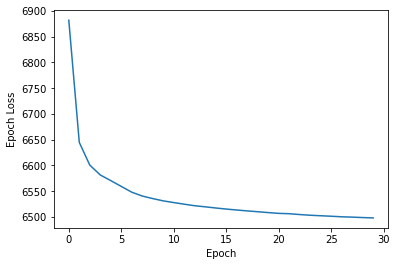

In [20]:
plt.xlabel("Epoch")
plt.ylabel("Epoch Loss")
plt.plot(loss_list)
plt.show()

<div id="9"></div>
# 9 模型效果对比

观察VAE模型生成的图像。发现与真实图像相比，VAE模型在经过30个Epoch的训练后，即使动漫头像的轮廓已经显示出来，但图像仍然较模糊。相比DCGAN模型，生成的效果更不理想，且运行速度较慢，VAE网络结构仍然需要优化。

In [56]:
# 获取图像
def get(x):
    return dataset[x][0].view(1, 3, image_size, image_size)

# 展示图像
def imshow(img):
    pic = np.transpose(img.numpy(), (1,2,0))
    plt.axis('off')
    return plt.imshow(pic, animated=True)

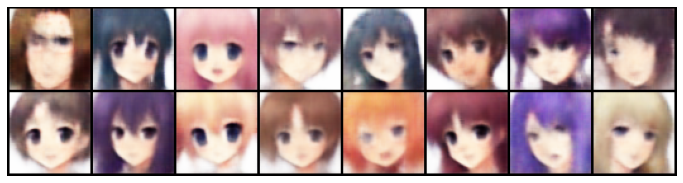

In [61]:
decoded_batch = model.decode(model.encode(real_batch[0]).data).data
plt.figure(figsize=(12,12))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(decoded_batch[:16], padding=2, normalize=True).cpu(),(1,2,0))) #normalize from [-1,1] to [0,1] again
plt.show()

<div id="10"></div>
# 10 总结

图像生成技术在现实中越发受到重视，它可以生成高质量的样本，扩大样本数据集，且能够修复人脸图像。本案例加载了动漫头像，介绍了DCGAN和VAE模型的网络结构，并展示如何使用Pytorch构建模型、训练数据集、生成新的动漫图像。根据训练结果，可以看到DCGAN模型的生成效果较好，但VAE模型的生成效果仍然有待提升，且运行速度较慢。
